# Gravpop tutorial

This is a library that allows you to perform a population analysis, ala [Thrane et. al](https://arxiv.org/abs/1809.02293), but using a trick described in [Hussain et. al](...) that allows one to be able to probe population features even when they get very narrow, and get close to the edges of a bounded domain. 

The trick essentially relies on dividing the parameter space into a sector (which we call the __analytic__ sector $\theta^a$) where our population model is made out of some weighted sum of multivariate truncated normals - where we can analytically compute the population likelihood, and another where the model is general and we can compute it using the monte-carlo estimate of the population likelihood (we call this sector the __sampled__ sector $\theta^s$). 

This trick involves representing the posterior samples as a truncated gaussian mixture model (TGMM). See [truncatedgaussianmixtures](https://github.com/Potatoasad/truncatedgaussianmixtures) for a package that can fit a dataset to a mixture of truncated gaussians. 


# Data
For this trick to work, we expect the data to be in a particular format. Given a dataset of $E$ events each fitted to a TGMM using $K$ components, we need the following to be able to do the analytic estimates of the likelihood integral. 

- For parameters that are in the __sampled sector__ (e.g. mass, redshift) we desire $N$ samples for every component to be able to do the monte-carlo estimates of the likelihood integral. For each parameter $x$ we desire 
    - $E\times K \times N$ array called `'x'`, representing the value of parameter $x$ in the sample
    - $E\times K \times N$ array called `'prior'`, representing the prior evaluated on each of these samples
    
- For parameters that are in the __analytic sector__ (e.g. spin orientation, spin magnitude) for each parameter $x$ we desire 
    - $E\times K$ array called `'x_mu_kernel'`, representing the location parameter of each TGMM component
    - $E\times K$ array called `'x_sigma_kernel'`, representing the scale parameter of each TGMM component
    - $E\times K$ array called `'x_rho_kernel'`, representing the corrleation parameter of each TGMM component with some other parameter (refer to the documentation of the generated data to infer which other coordinate this correlation correponds to).
    - $E\times K$ array called `'weights'`, representing the weight of each TGMM component

Here is an example of the form of the data that gwpop uses:

```python
{'mass_1_source' : [...],       # E x K x N Array
 'prior' : [...],               # E x K x N Array
 'chi_1_mu_kernel' : [...],     # E x K     Array
 'chi_1_sigma_kernel' : [...],  # E x K     Array
 'chi_2_mu_kernel' : [...],     # E x K     Array
 'chi_2_sigma_kernel' : [...],  # E x K     Array
 'chi_1_rho_kernel' : [...],    # E x K     Array
 'weights' : [...]              # E x K     Array
}
```


One can also load from a saved HDF5 dataproduct with the
following format: 

```python
{'GW150914': {'mass_1_source' : [...],       # K x N Array
              'prior' : [...],               # K x N Array
              'chi_1_mu_kernel' : [...],     # K     Array
              'chi_1_sigma_kernel' : [...],  # K     Array
              'chi_2_mu_kernel' : [...],     # K     Array
              'chi_2_sigma_kernel' : [...],  # K     Array
              'chi_1_rho_kernel' : [...],    # K     Array
              'weights' : [...]              # K     Array
             }
'GW190517' : ...
}
```

which is then internally converted upon loading


## Creating Fits to Data
A quick example way to perform this fitting using the `truncatedgaussianmixtures` library, given we have posterior samples (with precomputed priors), is the following:

Lets first pull the event data. The `load_hdf5_to_jax_dict` utility will pull in an hdf5 file containing datasets in some nested structure, and provide a dictionary with all datasets in the form of a dictionary of jax arrays. 

In [3]:
import pandas as pd
import jax
import jax.numpy as jnp
from gravpop import load_hdf5_to_jax_dict

event_data = load_hdf5_to_jax_dict("/Users/asadh/Documents/GitHub/SpinMagnitudePopulationAnalysis/data/posterior_samples/all_event_samples.hdf5");

pd.DataFrame(event_data['GW150914']).head(10)

,chi_1,chi_2,chirp_mass,cos_tilt_1,cos_tilt_2,mass_1_source,mass_ratio,prior,redshift
0,0.001930,0.097727,30.385015,0.648332,-0.889278,34.860180,0.846616,0.002376,0.088913
1,0.028095,0.041392,30.547218,-0.478594,-0.951041,34.373547,0.860291,0.003205,0.101225
2,0.225305,0.275129,31.643066,0.137109,0.303796,35.392544,0.852512,0.004326,0.113009
3,0.000255,0.453062,30.345112,0.380074,-0.241549,35.997993,0.765623,0.003989,0.108616
4,0.055366,0.084168,31.065317,-0.569629,-0.102006,34.082230,0.920346,0.002493,0.091574
5,0.618177,0.570168,30.133745,-0.140515,-0.041809,36.690060,0.734442,0.003609,0.103474
6,0.721023,0.114889,30.238930,-0.177807,-0.596842,40.232189,0.652075,0.001779,0.074039
7,0.002967,0.082386,31.107443,-0.801190,0.647356,36.535999,0.781811,0.003973,0.107783
8,0.026698,0.268805,30.639584,-0.344281,-0.528770,33.594978,0.893774,0.003713,0.108505
9,0.483900,0.414391,30.279470,0.298207,-0.782193,33.710155,0.855433,0.004422,0.116259


We can then fit the events we want to TGMMs. Note that the `.dataproduct()` method of the TGMM class provides the fitted data in the format that is required by `gravpop`.

In [4]:
from truncatedgaussianmixtures import fit_gmm, Transformation

example_events = ['GW150914', 'GW190517_055101']

a = [0,0,-6];
b = [1,1,2];

T1 = Transformation(
        ['chi_1', 'chi_2', 'redshift'],
        "(c1, c2, r) -> (c1, c2, log(r))",
        ['chi_1', 'chi_2', 'log_redshift'],
       "(c1, c2, r) -> (c1, c2, exp(r))",
        ['prior']
)


dataset = {event: pd.DataFrame(data) for event,data in event_data.items() if event in example_events}
TGMMs = {}

for event, data in dataset.items():
    TGMMs[event] = fit_gmm(data, 15, a, b,
                          transformation=T1,
                          cov="full", 
                          block_structure=[1,1,0], # This means that the first two parameters can be in the same
                                                  # correlation block
                         tol=1e-8, MAX_REPS=200, progress=True, 
                         boundary_unbiasing={'structure' : [1,1,0], # Perform KDE unbiasing in the first two dimensions only
                                             'bandwidth_scale' : 1.0} # Scale up the bandwidth relative to silverman's rule
                                            )

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


We can now construct the data product we need:



In [5]:
dataproducts = {}

for event in example_events:
    dataproducts[event] = TGMMs[event].data_product(sampled_columns=['redshift'],
                                                   analytic_columns=['chi_1', 'chi_2'],
                                                   N=1000)       # Number of samples per component
    
    
variables = dataproducts[example_events[0]].keys()
event_data = {col : jnp.stack([dataproducts[event][col] for event in example_events], axis=0) for col in variables};

print("Event Data with shapes: ")
for key in event_data.keys():
    print(f"{key} : {event_data[key].shape}")

Event Data with shapes: 
chi_1 : (2, 15, 1000)
chi_2 : (2, 15, 1000)
redshift : (2, 15, 1000)
prior : (2, 15, 1000)
chi_1_mu_kernel : (2, 15)
chi_1_sigma_kernel : (2, 15)
chi_1_rho_kernel : (2, 15)
chi_2_rho_kernel : (2, 15)
chi_2_mu_kernel : (2, 15)
chi_2_sigma_kernel : (2, 15)
weights : (2, 15)


we now have our data in the correct format. 

## Selection Injections

For injection sets the format we expect is:

```python
{'mass_1_source' : [...],       # K x N Array
 'prior' : [...],               # K x N Array
 'chi_1_mu_kernel' : [...],     # K     Array
 'chi_1_sigma_kernel' : [...],  # K     Array
 'chi_2_mu_kernel' : [...],     # K     Array
 'chi_2_sigma_kernel' : [...],  # K     Array
 'chi_1_rho_kernel' : [...],    # K     Array
 'weights' : [...]              # K     Array
}
```


One can also load from a saved HDF5 dataproduct with the
following format: 

```python
{'selection': {'mass_1_source' : [...],      # K x N Array
              'prior' : [...],               # K x N Array
              'chi_1_mu_kernel' : [...],     # K     Array
              'chi_1_sigma_kernel' : [...],  # K     Array
              'chi_2_mu_kernel' : [...],     # K     Array
              'chi_2_sigma_kernel' : [...],  # K     Array
              'chi_1_rho_kernel' : [...],    # K     Array
              'weights' : [...]              # K     Array
             }
}
```

where the `'selection'` dataset has additional attributes `analysis_time` and `total_generated`. This file structure is then internally converted to the one at the top upon loading.


# Models

One can specify population models using a set of building block models. Each population model is defined as a distributions over some parameters $\theta$, defined below by `var_names`, and some hyper-parameters $\Lambda$, defined below by `hyper_var_names`. 
The generic intialization of a `PopulationModel` object is the following:

```python
spin_pop_model = SomePopulationModel(var_names = ['chi_1', 'chi_2'],
                                    hyper_var_names = ['mu_chi_1', 'sigma_chi_1', 
                                                       'mu_chi_2', 'sigma_chi_2'],
                                    additional_arguments...)
```

and one can call these population models using the following generic call:

```python
params = {'mu_chi_1' : 0.1, 'sigma_chi_1' : 0.1,
          'mu_chi_2' : 0.1, 'sigma_chi_2' : 0.1}

spin_pop_model(data, params)
```

where `data` is the same dictionary we defined in the section on data.

Models are strictly of two types. __Sampled__ models, and __Analytic__ models. 

- __Sampled__ models will simply evaluate the population model on all the samples in a TGMM component.
    - `SampledModel(data = {sampled_var : E x K x N array, ...}, params) -> E x K x N array`
- __Analytic__ models will evaluate the __integral__ of the population model with the TGMM component in that sector.
    - `AnalyticModel(data = {analytic_var_mu_kernel : E x K array, ...}, params) -> E x K array`
    - These models often have a method called `.evaluate(data, params)`, which simply evaluates the model on the samples similar to the __Sampled__ model case
    - Currently the ony such models are some subset of truncated 2D multivarate normal distributions, uniform distributions, and mixtures thereof.
    

## Analytic Models
For analytic models, the building blocks are essentially
- 1D truncated normals $N_{[0,1]}(x | \mu, \sigma)$
- 2D truncated normals $N_{[0,1]}(x, y | \mu_x, \sigma_x, \mu_y, \sigma_y, \rho)$
- Uniform distributions $U(x | a, b)$

and can be initialized like:

In [1]:
import gravpop as gpop
from gravpop import TruncatedGaussian1DAnalytic, TruncatedGaussian2DAnalytic, Uniform1DAnalytic


TG1D = TruncatedGaussian1DAnalytic(a = 0, b = 1,          # Limits of the truncated normal
                                 var_names=['x'],
                                 hyper_var_names=['mu', 'sigma'])


TG2D = TruncatedGaussian2DAnalytic(a = [0,0], b = [1,1],          # Limits of the truncated normal
                                 var_names=['x', 'y'],
                                 hyper_var_names=['mu_x', 'sigma_x',
                                                  'mu_y', 'sigma_y',
                                                  'rho'])

U = Uniform1DAnalytic(a=0, b=1,
                      var_names=['x'],
                      hyper_var_names=[])

We can combine these building blocks however we like. Using the following operations:

- `ProductModel([model1, model2, ...])` : tensor product of multiple models
- `Mixture2D(model1, model2, mixture_hypervar_name)` : create a mixture of 2 models in 2D space
- `Mixture1D(model1, model2, mixture_hypervar_name)` : create a mixture of 2 models in 1D space
- `FixedParameters(model, {variable_name : value, ...})` : takes a model and fixes some of the parameters to a fixed value

For example lets create an analytic spin model:

$$
p(\chi_1, \chi_2) = \eta N_{[0,1]}(\chi_1 | \mu_1, \sigma_1) N_{[0,1]}(\chi_1 | \mu_2 = 0, \sigma_2) + (1-\eta)
$$

In [2]:
from gravpop import ProductModel, Mixture2D, FixedParameters

## Sub-population 1
TG1 = TruncatedGaussian1DAnalytic(a = 0, b = 1,          # Limits of the truncated normal
                                  var_names=['chi_1'],
                                  hyper_var_names=['mu_1', 'sigma_1'])

TG2 = TruncatedGaussian1DAnalytic(a = 0, b = 1,          # Limits of the truncated normal
                                  var_names=['chi_2'],
                                  hyper_var_names=['mu_2', 'sigma_2'])

TG2_fixed_mu = FixedParameters(TG2, {'mu_2' : 0.0})

TG2D = ProductModel([TG1, TG2_fixed_mu])

## Sub-population 2
U1 = Uniform1DAnalytic(a = 0, b = 1, var_names=['chi_1'])
U2 = Uniform1DAnalytic(a = 0, b = 1, var_names=['chi_2'])
U2D = ProductModel([U1, U2])

## Combine population model
spin_model = Mixture2D(TG2D, U2D, "eta")

One can then evaluate this spin model on some set parameters

In [9]:
params = {'mu_1' : 0.1, 'sigma_1' : 0.3, 
          'sigma_2' : 0.1, 'eta' : 0.5} # No 'mu_2' since that is fixed


spin_model(event_data, params) # E x K array

Array([[1.0847163 , 0.8979634 , 0.74254215, 0.91504437, 0.8520578 ,
        1.6162018 , 0.8624244 , 0.9970297 , 0.83357495, 1.1137404 ,
        1.3483851 , 0.8516542 , 1.1989837 , 2.4569511 , 0.9972198 ],
       [0.550054  , 0.5194446 , 0.545067  , 0.5287251 , 0.5653681 ,
        0.59392554, 0.5459557 , 0.5379501 , 0.546056  , 0.53605664,
        0.51603144, 0.5286484 , 0.54004896, 0.5150053 , 0.51524615]],      dtype=float32)

## Sampled Models

Sampled models can be similarly combined. Some common sampled models used in analysis of LVK events are:

- `PowerLawPlusPeak` mass model, known in this package as `SmoothedTwoComponentPrimaryMassRatio`
- `PowerLaw` redshift modell, known in this package as `PowerLawRedshift`


## Making Custom models

Custom models can be made. We use duck-typing, so any class you create that has the following methods/properties should just work:

__Required__:
- `.__call__(data={var1 : E x K x N array, ...}, params) -> E x K x N array,` or an `E x K` array in the case of an analytic model
- `.limits` gives a dictionary of limits for each variable (e.g. `{'chi_1' : [0,1], chi_2' : [0,1]}`) 

__Recommended__:
- `.sample(df_hyper_parameters, oversample=1)` will sample variables from the population model, given a dataframe of hyperparameters `df_hyper_parameters`. `oversample` will simply perform this operation `oversample` number of times and concatenate the result.

# Population Likelihood

The main object that will allow us to perform this analysis, is the `HybridPopulationLikelihood` object. We can construct it directly, or load data from a file.

For example, lets perform a population analysis over ($\chi_1$, $\chi_2$, $z$). We will use the `PowerLawRedshift` model for $z$, and the `spin_model` we defined before for the component spins:

$$
p(\chi_1, \chi_2) = \eta N_{[0,1]}(\chi_1 | \mu_1, \sigma_1) N_{[0,1]}(\chi_1 | \mu_2 = 0, \sigma_2) + (1-\eta)
$$

which will be handled analytically (since we created a model using the analytic primitives).

We will use the dataset of two events we fit TGMMs to before, and no selection effects. 

In [15]:
from gravpop import HybridPopulationLikelihood
from gravpop import PowerLawRedshift

redshift_model = PowerLawRedshift(var_names=['redshift'], hyper_var_names=['lamb'])

HL = HybridPopulationLikelihood(
        event_data = event_data,
        event_names = example_events,
        sampled_models=[redshift_model],
        analytic_models=[spin_model]
    )

No selection function provided


We can compute the loglikelihood for some hyper-parameters, and also confirm by computing the derivative that there are no nan derivatives.

The method for computing the log likelihood is `logpdf(params)` where params is a dictionary of hyper-parameter : value pairs.

In [16]:
params = {'mu_1' : 0.1, 'sigma_1' : 0.3, 
          'sigma_2' : 0.1, 'eta' : 0.5,
          'lamb' : 2.9}

HL.logpdf(params)

Array(-3.0299485, dtype=float32)

All our models are auto-diff-able, so we can compute the gradient of the logpdf as below:

In [18]:
import jax

jax.jacrev(lambda x: HL.logpdf(x))(params)

{'eta': Array(-1.3198029, dtype=float32, weak_type=True),
 'lamb': Array(-1.8767387, dtype=float32, weak_type=True),
 'mu_1': Array(0.18516624, dtype=float32, weak_type=True),
 'sigma_1': Array(0.6543136, dtype=float32, weak_type=True),
 'sigma_2': Array(-0.05872979, dtype=float32, weak_type=True)}

One can also load up the event and selection function data from a file:

In [19]:
import gravpop as gpop

HL = gpop.HybridPopulationLikelihood.from_file(
    event_data_filename="/Users/asadh/Documents/GitHub/SpinMagnitudePopulationAnalysis/data/TGMM_fits/event_data.hdf5",
    selection_data_filename="/Users/asadh/Documents/GitHub/SpinMagnitudePopulationAnalysis/data/TGMM_fits/selection_data.hdf5",
    sampled_models=[redshift_model],
    analytic_models=[spin_model]
)

# Sampling

Now that we have our population likelihood set up, we can begin defining our hyper priors and sampling from the population model. 

For the priors we expect a dictionary of numpyro distributions

In [22]:
import numpyro.distributions as dist


priors = {
    'mu_1' : dist.Uniform(0,1), 
    'sigma_1' : dist.Uniform(0,1), 
    'sigma_2' : dist.Uniform(0,1), 
    'eta' : dist.Uniform(0,1),
    'lamb' : dist.Uniform(0,1)
}

Then, we can construct a `Sampler` object and put in our settings.

In [24]:
from gravpop import Sampler

samp = Sampler(priors=priors,
               latex_symbols=None,
               likelihood = HL,
               num_samples=1000, num_warmup=500);

and we can begin sampling

In [25]:
samp.sample()

sample: 100%|█████████████████████████████████| 1500/1500 [03:35<00:00,  6.95it/s, 7 steps of size 5.01e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      0.82      0.11      0.83      0.66      1.00    608.09      1.00
      lamb      0.20      0.19      0.15      0.00      0.47    559.06      1.00
      mu_1      0.15      0.09      0.15      0.00      0.27    409.37      1.00
   sigma_1      0.16      0.11      0.15      0.00      0.29    583.60      1.00
   sigma_2      0.12      0.11      0.09      0.00      0.24    776.21      1.00

Number of divergences: 0


we can see the dataframe holding the hyper-posterior samples in:

In [28]:
samp.samples

,eta,lamb,mu_1,sigma_1,sigma_2
0,0.476112,0.071545,0.090596,0.105491,0.077657
1,0.460751,0.095909,0.048131,0.113161,0.130583
2,0.592883,0.289967,0.315391,0.284772,0.199418
3,0.978045,0.010133,0.082620,0.111385,0.073198
4,0.975931,0.428702,0.117799,0.270596,0.155701
...,...,...,...,...,...
995,0.790344,0.017701,0.017430,0.074497,0.001218
996,0.641068,0.332459,0.011991,0.334153,0.004681
997,0.863573,0.144214,0.000969,0.113832,0.059052
998,0.765053,0.170739,0.008454,0.110767,0.134668


and here is a corner plot of our result

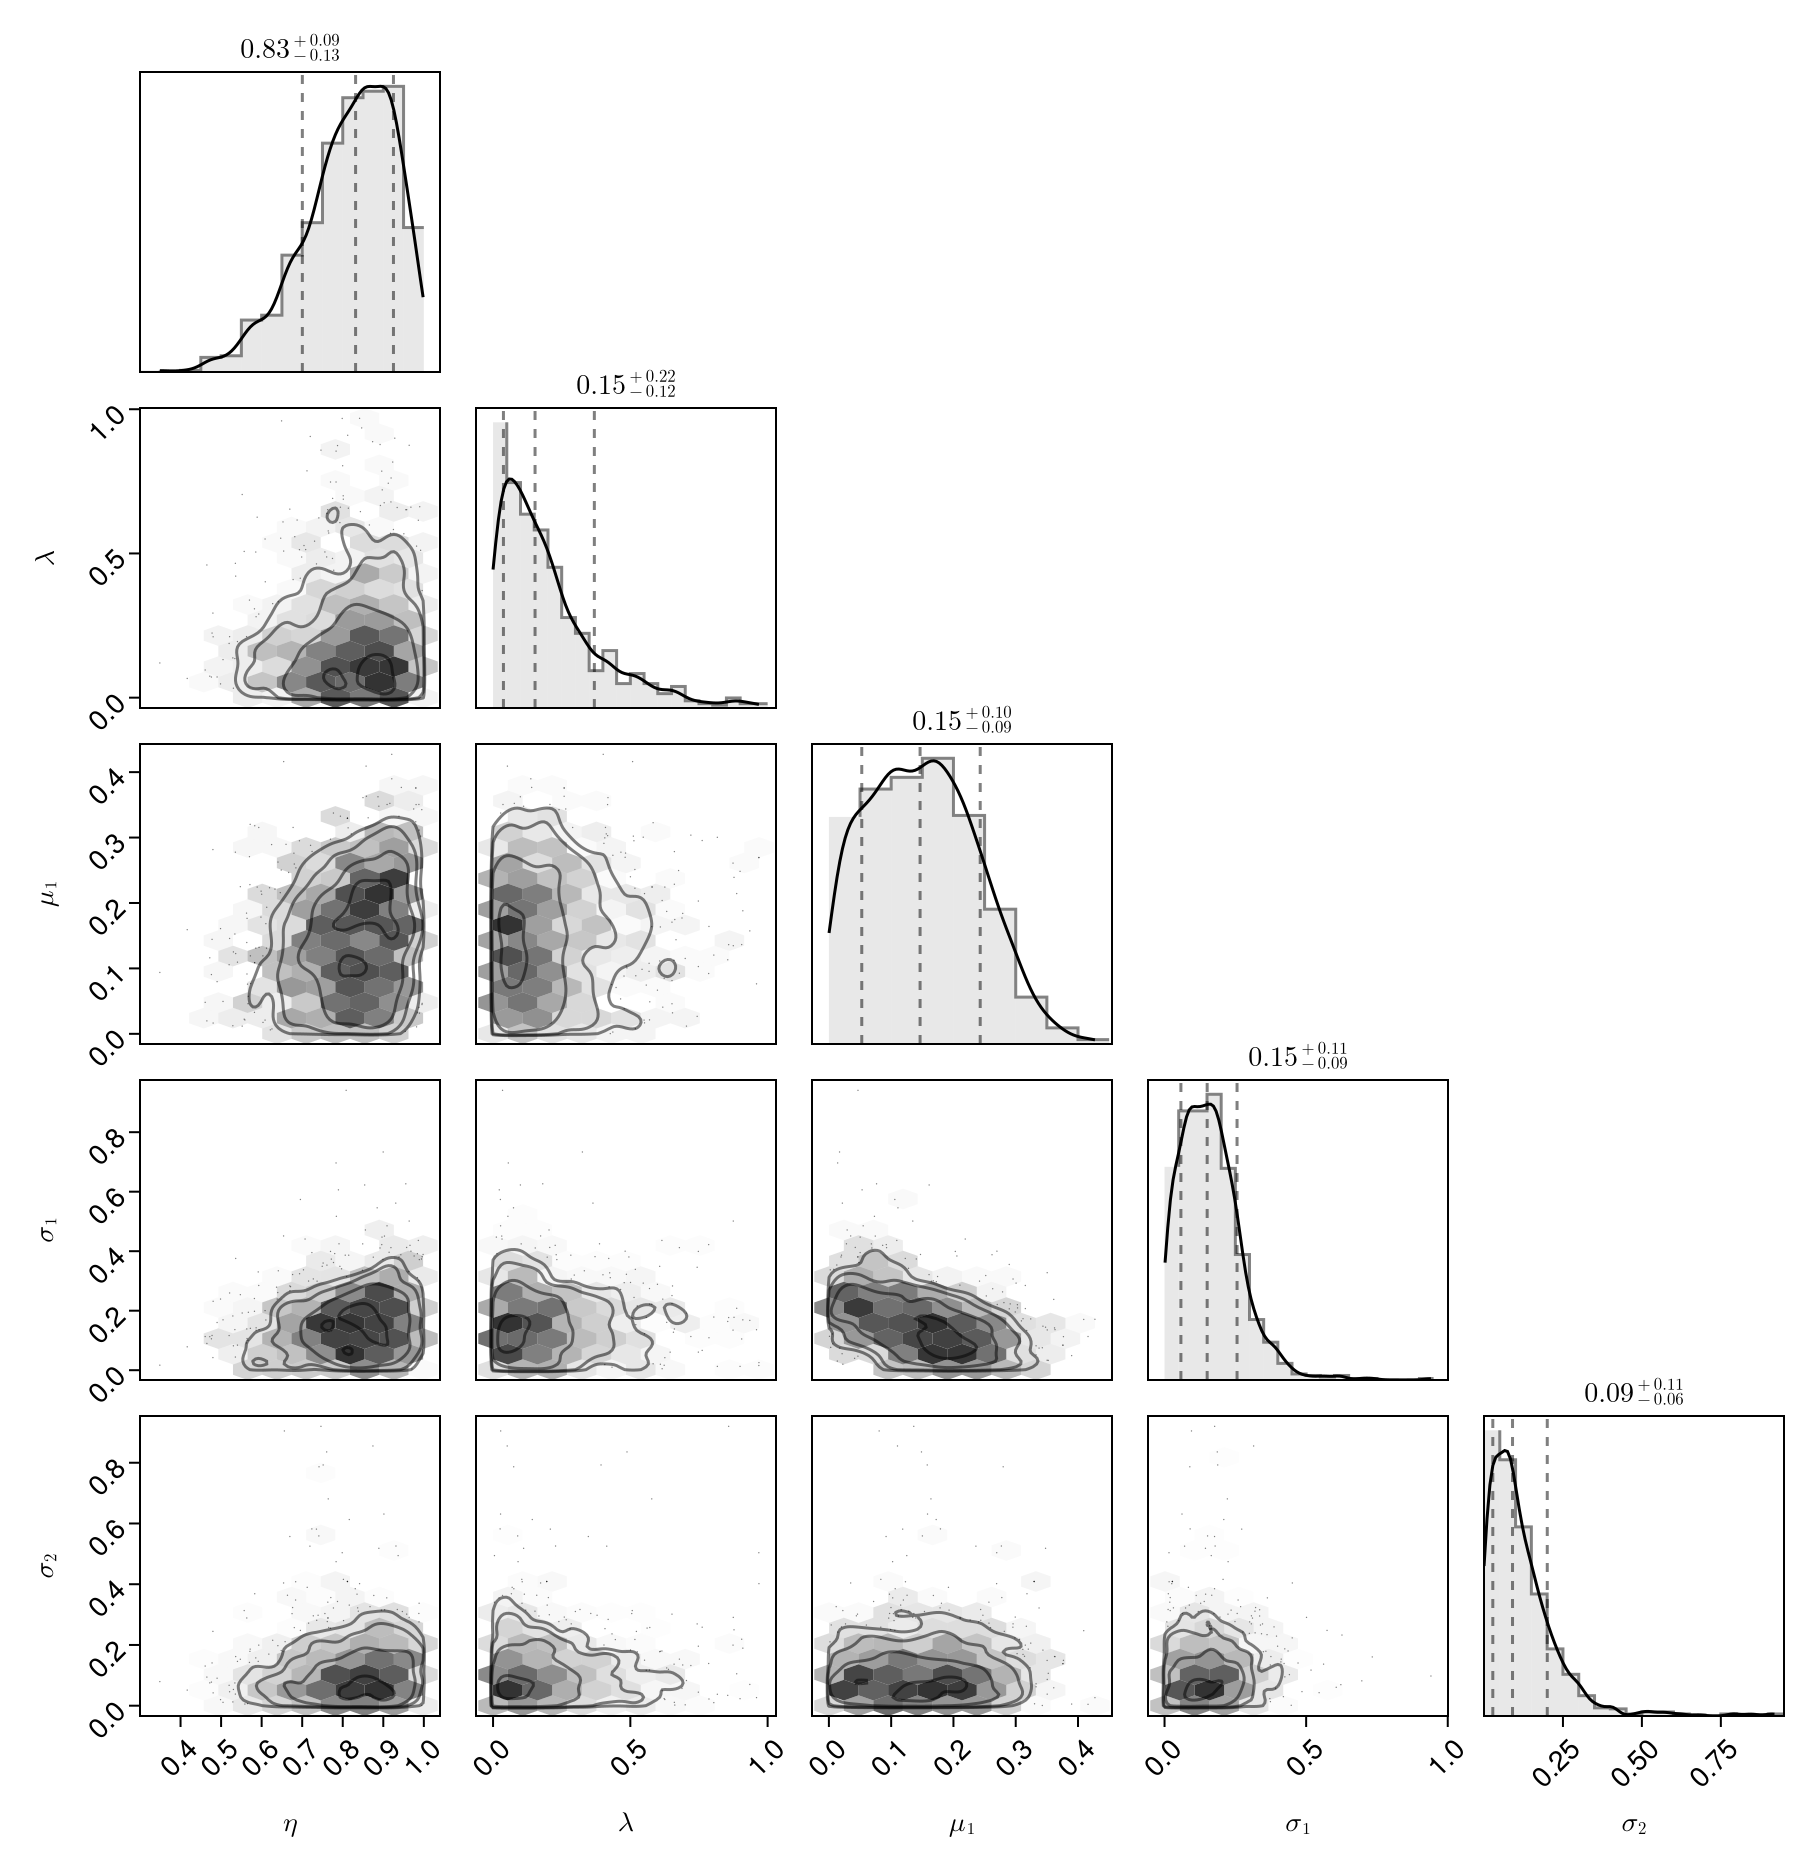

In [31]:
import pairplots


pairplots.pairplot(samp.samples, 
                  labels={'mu_1' : pairplots.latex(r'\mu_1'), 
                          'sigma_1' : pairplots.latex(r'\sigma_1'), 
                          'sigma_2' : pairplots.latex(r'\sigma_2'), 
                          'eta' : pairplots.latex(r'\eta'),
                          'lamb' : pairplots.latex(r'\lambda')})